# Regrid data to model grid

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import subprocess
from glob import glob

import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import pop_tools
import util2
import numpy as np
from datetime import date, datetime, timezone

## Setup parameters

In [3]:
src_grid = 'POP_gx1v7'
dst_grid = 'POP_tx0.1v3'
method = 'conserve'

clobber = True

get_dst_grid = pop_tools.get_grid

In [4]:
def get_regridder(src_grid, dst_grid, method):

    os.makedirs('data/regridding', exist_ok=True)
    dst_grid_file= f'data/regridding/{dst_grid}.nc'
    src_grid_file = f'data/regridding/{src_grid}.nc'
    weight_file = f'data/regridding/{src_grid}_to_{dst_grid}_{method}.nc'

    if not os.path.exists(src_grid_file) or clobber:
        dso = get_dst_grid(src_grid, scrip=True)
        print(f'writing {src_grid_file}')
        dso['grid_imask'].data[:]=1
        print(dso)
        dso.to_netcdf(src_grid_file)    
        
    if not os.path.exists(dst_grid_file) or clobber:
        dso = get_dst_grid(dst_grid, scrip=True)
        print(f'writing {dst_grid_file}')
        #dso
        dso.to_netcdf(dst_grid_file)    
        
    if not os.path.exists(weight_file) or clobber:
        cmd = ['ESMF_RegridWeightGen', '--netcdf4', '--ignore_unmapped',
                    '-s', src_grid_file, '-d', dst_grid_file, '-m', method, '-w', weight_file]
        out = subprocess.run(cmd, capture_output=True, check=True)
        print(out.stdout.decode('UTF-8'))
        
    return util2.regridder(src_grid_file, dst_grid_file, weight_file)        

regrid_op = get_regridder(src_grid, dst_grid, method)
regrid_op

/glade/work/kristenk/miniconda/envs/analysis5/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


writing data/regridding/POP_gx1v7.nc
<xarray.Dataset>
Dimensions:          (grid_corners: 4, grid_rank: 2, grid_size: 122880, nreg: 13)
Coordinates:
  * nreg             (nreg) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: grid_corners, grid_rank, grid_size
Data variables:
    grid_dims        (grid_rank) int32 320 384
    grid_center_lat  (grid_size) float64 -79.22 -79.22 -79.22 ... 72.19 72.19
    grid_center_lon  (grid_size) float64 -39.44 -38.31 -37.19 ... -40.65 -40.22
    grid_corner_lat  (grid_size, grid_corners) float64 -78.95 -78.95 ... 71.96
    grid_corner_lon  (grid_size, grid_corners) float64 321.1 320.0 ... 320.0
    grid_imask       (grid_size) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    region_name      (nreg) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'
    region_val       (nreg) int64 -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    hor

regridder POP_gx1v7.nc --> POP_tx0.1v3.nc

In [5]:
# def get_ClusterClient():
#     import dask
#     from dask_jobqueue import PBSCluster
#     from dask.distributed import Client
#     cluster = PBSCluster(
#         cores=2,
#         memory='256GB',
#         processes=1,
#         queue='casper',
#         resource_spec='select=1:ncpus=2:mem=256GB',
#         project='NCGD0011',
#         walltime='04:00:00',
#         interface='ib0',)

#     dask.config.set({
#         'distributed.dashboard.link':
#         'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
#     })
#     client = Client(cluster)
#     return cluster, client

# cluster, client = get_ClusterClient()
# cluster.scale(12) 

In [6]:
#client

In [7]:
tracernames = ['O2','NO3'] #'diazC', 'diazChl', 'diazFe', 'diazP',
#     'coccoC', 'coccoChl', 'coccoFe', 'coccoP', 'coccoCaCO3',
#     'microzooC','mesozooC',
#     'DOC', 'DOCr', 'DON', 'DONr', 'DOP', 'DOPr', 'NH4',
#     'Fe', 'Lig',
#     'ALK_ALT_CO2','DIC_ALT_CO2', #added these here
#     'NO3', 'PO4', 'SiO3', 'O2', 'DIC', 'ALK',
#     'spC', 'spChl', 'spFe', 'spP',
#     'diatC', 'diatChl', 'diatFe', 'diatP', 'diatSi',
# ]

In [8]:
refcase = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.001'
refdate = '0306-01-01'
dirin_refcase = f'/glade/scratch/kristenk/archive/{refcase}/rest/{refdate}-00000'
fname_refcase = f'{dirin_refcase}/{refcase}.pop.r.{refdate}-00000.nc'

In [9]:
ds_out = pop_tools.get_grid(grid_name=dst_grid)

# add z_t_bounds
z_t_edges = np.concatenate(([0.0], np.cumsum(ds_out.dz)))
z_t_bounds_vals = np.stack((z_t_edges[:-1], z_t_edges[1:]), axis=1)
ds_out['z_t_bounds'] = xr.DataArray(z_t_bounds_vals, dims=('z_t', 'd2'),
                                   coords={'z_t':ds_out.z_t})
ds_out['z_t'].attrs['bounds'] = 'z_t_bounds'

In [10]:
# generate 3D grid masks

def gen_MASK(ds_grid):
    nk = len(ds_grid.z_t)
    nj, ni = ds_grid.KMT.shape

    # make 3D array of 0:km
    zero_to_km = xr.DataArray(np.arange(0, nk), dims=('z_t'))
    ONES_3d = xr.DataArray(np.ones((nk, nj, ni)), dims=('z_t', 'nlat', 'nlon'))
    ZERO_TO_KM = (zero_to_km * ONES_3d)

    # mask out cells where k is below KMT
    MASK = ZERO_TO_KM.where(ZERO_TO_KM < ds_grid.KMT)
    MASK = xr.where(MASK.notnull(), True, False)

    MASK['z_t'] = ds_grid.z_t

    return MASK

MASK_out = gen_MASK(ds_out)
(nk_out, nj_out, ni_out) = MASK_out.shape

grid_refcase = pop_tools.get_grid(grid_name=src_grid)
MASK_refcase = gen_MASK(grid_refcase)
(nk_refcase, nj_refcase, ni_refcase) = MASK_refcase.shape

In [11]:
ds_grid = pop_tools.get_grid('POP_gx1v7')

nk = len(ds_grid.z_t)
nj, ni = ds_grid.KMT.shape

In [12]:
ONES_3d = xr.DataArray(np.ones((nk, nj, ni)), dims=('z_t', 'nlat', 'nlon'))

In [13]:
MASK = xr.where(ONES_3d.notnull(), True, False)

### do lateral fill on x1

In [14]:
filled_ds_refcase = xr.Dataset()

In [15]:
ds_refcase = xr.open_dataset(fname_refcase).rename({'k':'z_t', 'j':'nlat', 'i':'nlon'})
ds_refcase['z_t'] = ds_out['z_t'][0:nk_refcase]
ltripole = True

In [16]:
for v in tracernames:
    print(v)
    tracer = ds_refcase[v+'_CUR']
    tracer = tracer.where(MASK_refcase)
        
    
    # perform lateral fill
    #ds_out[v] = pop_tools.lateral_fill(ds_out[v], MASK_out, ltripole=ltripole) #, iter_max=1000, use_dask=True)
    filled_ds_refcase[v] = pop_tools.lateral_fill(tracer, MASK, ltripole=False, use_sor=True, max_iter=1000) 

O2
NO3


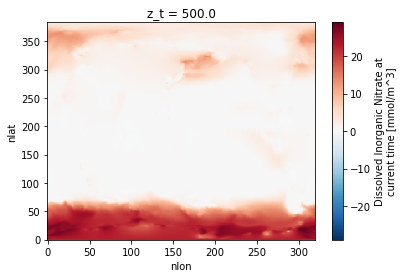

In [17]:
filled_ds_refcase.NO3.isel(z_t=0).plot()

In [19]:
# dirout = '/glade/scratch/kristenk/cesm_inputdata'
# os.makedirs(dirout, exist_ok=True)

In [20]:
%%time

for v in tracernames:
    print(v)
    tracer = filled_ds_refcase[v]
    #tracer = tracer.where(MASK_refcase)
        
    ds_out[v] = regrid_op.regrid_dataarray(
        filled_ds_refcase[v],
        renormalize=True, 
        apply_mask=True) #True
    
    ds_out[v].attrs = ds_refcase[v+'_CUR'].attrs
    ds_out.attrs = ds_refcase.attrs
    
    # perform lateral fill
    #ds_out[v] = pop_tools.lateral_fill(ds_out[v], MASK_out, ltripole=ltripole) #, iter_max=1000, use_dask=True)
    #ds_out[v] = pop_tools.lateral_fill(ds_out[v], MASK_out, ltripole=ltripole, use_sor=True, max_iter=1000) 
    
    # perform vertical fill
    unfilled = ds_out[v].isnull() & (MASK_out == 1.)                    
    if unfilled.any():
        for k in range(1, nk_out):
            ds_out[v][k, :, :] = xr.where(unfilled[k, :, :],
                                               ds_out[v][k-1, :, :],
                                               ds_out[v][k, :, :])
        if (ds_out[v].isnull() & (MASK_out == 1.)).any():
            print(f'{v} still has missing values')
            
    ds_out[v] = ds_out[v].where(MASK_out == 1.)

O2
NO3
CPU times: user 25.9 s, sys: 36.1 s, total: 1min 1s
Wall time: 1min 4s


In [21]:
np.sum(np.isnan(ds_out.NO3.isel(z_t=0)))

<xarray.DataArray 'NO3' ()>
array(3237440)
Coordinates:
    z_t      float64 500.0

In [22]:
np.sum(1-MASK_out.isel(z_t=0))

<xarray.DataArray ()>
array(3237440)
Coordinates:
    z_t      float64 500.0

### Read in the eight tracers I interpolated Keith's way

In [23]:
ds_compare=xr.open_dataset('/glade/scratch/kristenk/ds_out_8tracers.nc')
ds_compare

<xarray.Dataset>
Dimensions:      (d2: 2, nlat: 2400, nlon: 3600, z_t: 62, z_w: 62, z_w_bot: 62)
Coordinates:
    TLAT         (nlat, nlon) float64 ...
    TLONG        (nlat, nlon) float64 ...
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05 5.75e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5.5e+05 5.75e+05 6e+05
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/17)
    ULAT         (nlat, nlon) float64 ...
    ULONG        (nlat, nlon) float64 ...
    DXT          (nlat, nlon) float64 ...
    DYT          (nlat, nlon) float64 ...
    TAREA        (nlat, nlon) float64 ...
    KMT          (nlat, nlon) int32 ...
    ...           ...
    NO3          (z_t, nlat, nlon) float64 ...
    PO4          (z_t, nlat, nlon) float64 ...
    SiO3         (z_t, nlat, nlon) float64 ...
    O2           (z_t, nlat, nlon) float64 ...
    DIC          (z_t, nlat, nlon) float64 ...
    ALK          (z_t, nlat, nlon) float64 ...
Attributes:
    lateral_dims:       [2400 3600]
    vertical_dims:      62
    vert_grid_file:     /glade/work/kristenk/miniconda/envs/analysis2/lib/pyt...
    horiz_grid_fname:   /glade/p/cesmdata/cseg/inputdata/ocn/pop/tx0.1v3/grid...
    topography_fname:   /glade/p/cesmdata/cseg/inputdata/ocn/pop/tx0.1v3/grid...
    region_mask_fname:  /glade/p/cesmdata/cseg/inputdata/ocn/pop/tx0.1v3/grid...
    type:               tripole
    title:              POP_tx0.1v3 grid

### Compare the fields

### NO$_3$

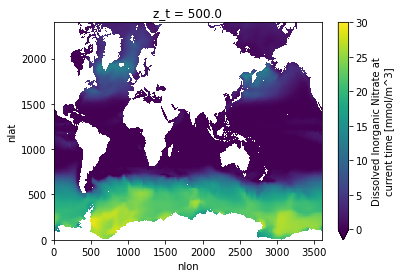

In [41]:
ds_out.NO3.isel(z_t=0).plot(vmin=0,vmax=30)

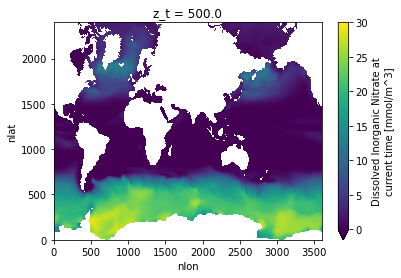

In [42]:
ds_compare.NO3.isel(z_t=0).plot(vmin=0,vmax=30)

In [64]:
diff = ds_compare.NO3.isel(z_t=0) - ds_out.NO3.isel(z_t=0)

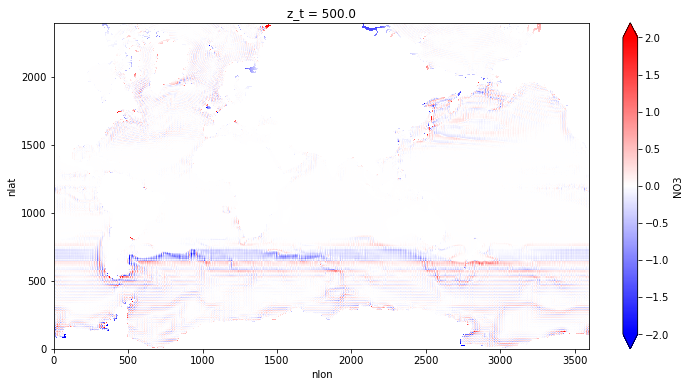

In [65]:
diff.plot(figsize=(12,6),vmin=-2,vmax=2,cmap='bwr');

### O$_2$

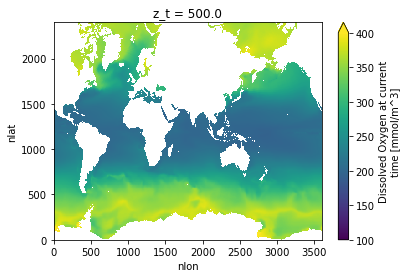

In [44]:
ds_out.O2.isel(z_t=0).plot(vmin=100,vmax=400)

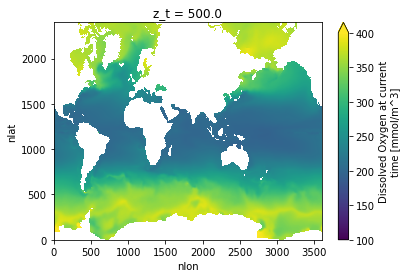

In [45]:
ds_compare.O2.isel(z_t=0).plot(vmin=100,vmax=400)

In [46]:
diff = ds_compare.O2.isel(z_t=0) - ds_out.O2.isel(z_t=0)

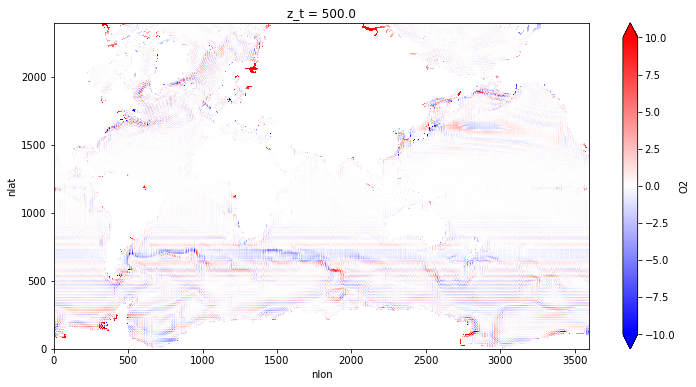

In [47]:
diff.plot(figsize=(12,6),vmin=-10,vmax=10,cmap='bwr');

### Look at O2 at ~500m

In [59]:
ds_out.z_t[32].values

array(48273.6729)

In [57]:
diff = ds_compare.O2.isel(z_t=32) - ds_out.O2.isel(z_t=32)

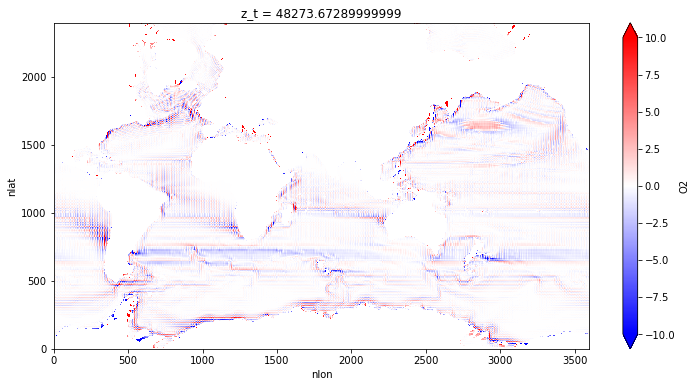

In [58]:
diff.plot(figsize=(12,6),vmin=-10,vmax=10,cmap='bwr');

### Look at O2 1000m

In [61]:
ds_out.z_t[39].values

array(98470.5867)

In [62]:
diff = ds_compare.O2.isel(z_t=39) - ds_out.O2.isel(z_t=39)

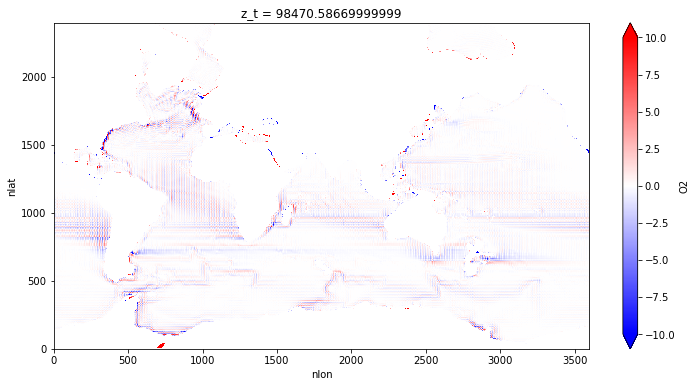

In [63]:
diff.plot(figsize=(12,6),vmin=-10,vmax=10,cmap='bwr');

### Check to make sure vertical section looks the same (lon section is approximate)

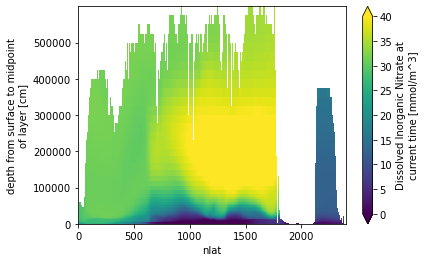

In [34]:
ds_out.NO3.isel(nlon=3000).plot(vmin=0, vmax=40);

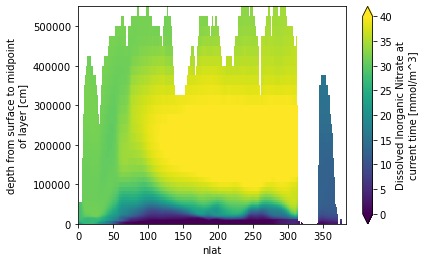

In [35]:
ds_refcase.NO3_CUR.where(MASK_refcase==1).isel(nlon=210).plot(vmin=0, vmax=40);

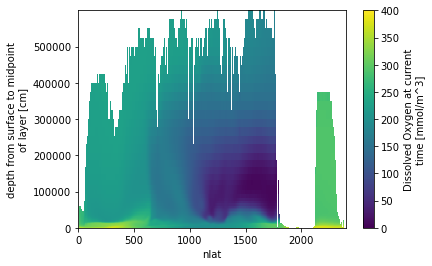

In [48]:
ds_out.O2.isel(nlon=3000).plot(vmin=0, vmax=400);

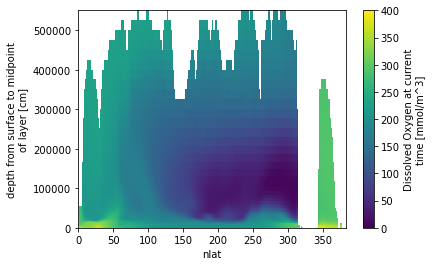

In [49]:
ds_refcase.O2_CUR.where(MASK_refcase==1).isel(nlon=210).plot(vmin=0, vmax=400);